In [2]:
import numpy as np
import os
import matlab.engine
import matplotlib.pyplot as plt
from Camera_util import parse_mean_video
import pandas as pd
from natsort import natsorted
import time
import Camera_util 
import importlib
import pickle

In [ ]:
settings_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings_metadata'
videos = [(file, pickle.load(os.path.join(settings_dir, file))) for file in os.listdir(settings_dir) if (file != '.DS_Store' and '25.0hz' in file)]
settings = []


for file in os.listdir(settings_dir):
    if (file != '.DS_Store' and '12.0hz' in file):
        pass





In [2]:
eng = matlab.engine.start_matlab()
dir_ = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings'
videos = [(file, parse_mean_video(os.path.join(dir_, file))) for file in os.listdir(dir_) if (file != '.DS_Store' and '25.0hz' in file)]
frequency = 6
light_level = 0

Generating TTF : 0NDF
Reading in 200FPS 0NDF videos...
Reading 0NDF 0.2hz from 200FPS_0.2hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_0.2hz_0NDF_settingsHistory.pkl
Reading 0NDF 0.5hz from 200FPS_0.5hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_0.5hz_0NDF_settingsHistory.pkl
Fitting Source vs Observed Modulation: 0NDF 0.2hz
Observed FPS: 200.00203265468897
R2: 0.4486546049663694
Amplitude: 0.3114698488423136
Fitting Source vs Observed Modulation: 0NDF 0.5hz
Observed FPS: 200.2113036674481
R2: 0.9990334859020829
Amplitude: 0.4500278213024846
Generating TTF : 1NDF
Reading in 200FPS 1NDF videos...
Reading 1NDF 0.2hz from 200FPS_0.2hz_1NDF.avi
Warmup settings from: 200FPS_0hz_1NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_0.2hz_1NDF_settingsHistory.pkl
Reading 1NDF 0.5hz from 200FPS_0.5hz_1NDF.avi
Warmup settings from: 200FPS_0hz_1NDF_warmup_settingsHistory.pk

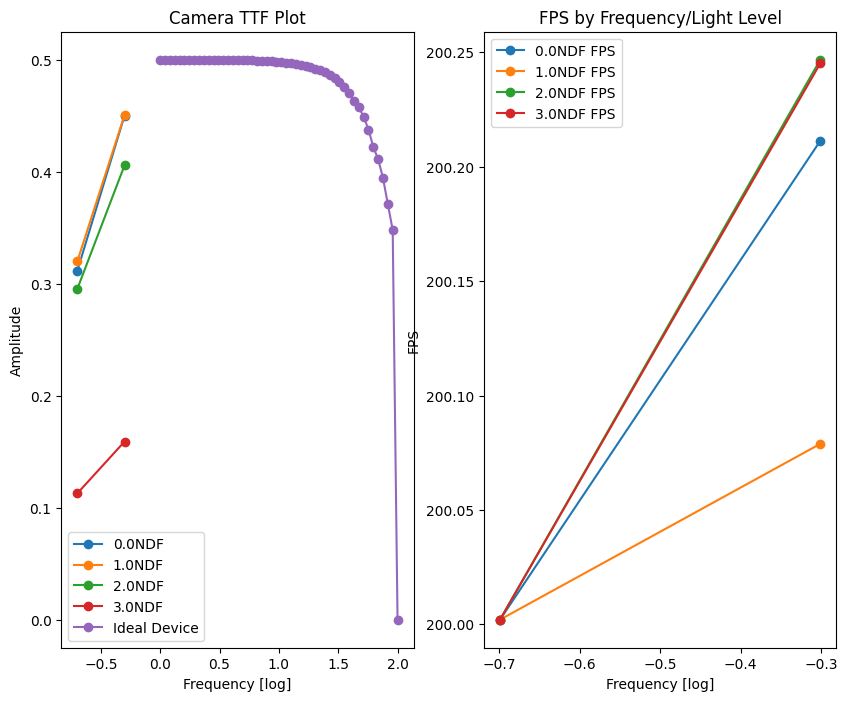

In [5]:
importlib.reload(Camera_util)
recordings_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings'
experiment_filename = '200FPS'
light_levels = [str(i) for i in range(4)]
save_dir = 'test'
Camera_util.generate_TTF(recordings_dir, experiment_filename, light_levels, save_dir)

In [3]:
print([(filename, video.shape) for (filename, video) in videos])

[('200FPS_25.0hz_3NDF.avi', (2005,)), ('200FPS_25.0hz_1NDF.avi', (1996,)), ('200FPS_25.0hz_2NDF.avi', (2005,)), ('200FPS_25.0hz_0NDF.avi', (2004,))]


Text(0.5, 0, 'Frame number')

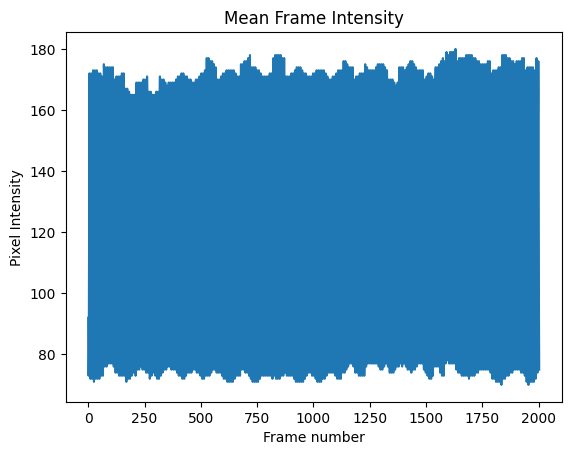

In [4]:
videos = [(file, video) for (file, video) in videos if '0NDF' in file]

to_plot = videos[0]


plt.plot(to_plot[1])
plt.title('Mean Frame Intensity')
plt.ylabel('Pixel Intensity')
plt.xlabel('Frame number')


Observed FPS: 200.18702764390025
R2: 0.9451145265747071
Amplitude: 0.40197669919214757


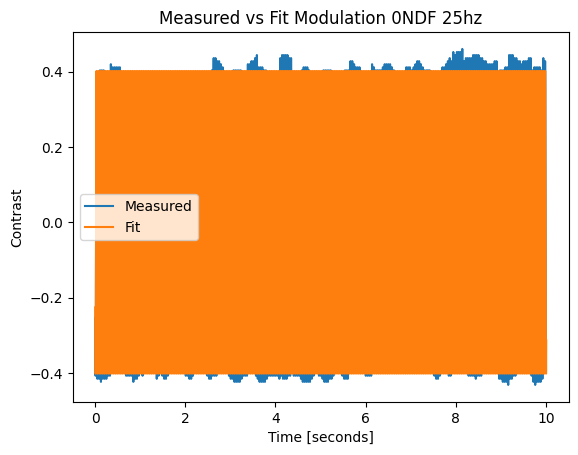

In [6]:
importlib.reload(Camera_util)
fig, ax = plt.subplots(1,1)
for video_num, (filename, signal) in enumerate(videos):
    Camera_util.fit_source_modulation(signal, '0', 25, ax)

In [ ]:
for i, (video_name, video_data) in enumerate(zip(findings_df['video_name'], data_table)):
    for j, fps in enumerate((200, 200.4)):
        observed_signal_T, signal, observed_model_T, observed_fit = video_data[j]


        plt.plot(observed_signal_T, signal, linestyle='-', label="Measured")
        plt.plot(observed_model_T, observed_fit, linestyle='-', label="Fit")
        plt.legend()
        plt.title(f"{os.path.basename(video_name)} Measured vs Fit Modulation {fps}FPS WHOLE")
        plt.xlabel('Time [seconds]')
        plt.ylabel('Contrast')

        plt.show()


        plt.plot(observed_signal_T[-250:], signal[-250:], linestyle='-', label="Measured")
        plt.plot(observed_model_T[-10000:], observed_fit[-10000:], linestyle='-', label="Fit")
        plt.legend()
        plt.title(f"{os.path.basename(video_name)} Measured vs Fit Modulation {fps}FPS ZOOMED")
        plt.xlabel('Time [seconds]')
        plt.ylabel('Contrast')
        

        plt.show()






In [7]:
eng.quit()